In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import *
from tensorflow.keras import Model
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

import seaborn as sns
import cv2
import re
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
dataset_dir = '../input/ranzcr-clip-catheter-line-classification/'
train_df = pd.read_csv(os.path.join(dataset_dir, 'train.csv'))

train_img = os.path.join(dataset_dir,'train')
train_annotations_df = pd.read_csv(os.path.join(dataset_dir, 'train_annotations.csv'))

In [3]:
train_df.head(5)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [4]:
seed = 456
batch_size = 16
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
img_size = 256
train_tfr = os.path.join(dataset_dir, "train_tfrecords")

autotune = tf.data.experimental.AUTOTUNE

feature_map = {
        'ETT - Abnormal' : tf.io.FixedLenFeature([], tf.int64),
        'ETT - Borderline' : tf.io.FixedLenFeature([], tf.int64),
        'ETT - Normal' : tf.io.FixedLenFeature([], tf.int64),
        "NGT - Abnormal" : tf.io.FixedLenFeature([], tf.int64),
        'NGT - Borderline' : tf.io.FixedLenFeature([], tf.int64),
        'NGT - Incompletely Imaged' : tf.io.FixedLenFeature([], tf.int64),
        'NGT - Normal' : tf.io.FixedLenFeature([], tf.int64),
        'CVC - Abnormal' : tf.io.FixedLenFeature([], tf.int64),
        'CVC - Borderline': tf.io.FixedLenFeature([], tf.int64),
        'CVC - Normal': tf.io.FixedLenFeature([], tf.int64),
        'StudyInstanceUID' : tf.io.FixedLenFeature([], tf.string),
        'Swan Ganz Catheter Present' : tf.io.FixedLenFeature([], tf.int64),
        'image' : tf.io.FixedLenFeature([], tf.string)
    }

In [6]:
def read_tfrecords(example):
    example = tf.io.parse_single_example(example, feature_map)
    #decoding images
    image = tf.image.decode_jpeg(example['image'])
    #converting grayscale to rgb
    image = tf.image.grayscale_to_rgb(image)
    #resizing images
    image = tf.image.resize(image, (img_size, img_size))
    
    if augmenter:
        image = augment(image)
    
    image = image/255
    
    features = tf.stack([
        example['ETT - Abnormal'],
        example['ETT - Borderline'],
        example['ETT - Normal'],
        example["NGT - Abnormal"],
        example['NGT - Borderline'],
        example['NGT - Incompletely Imaged'],
        example['NGT - Normal'],
        example['CVC - Abnormal'],
        example['CVC - Borderline'],
        example['CVC - Normal'],
        example['Swan Ganz Catheter Present']
        ])
    
    
    return image, features

In [7]:
import tensorflow_addons as tfa

def load_dataset(filenames, aug):
    
    tfrecords = tf.data.TFRecordDataset(filenames)
    
    tfrecords = tfrecords.map(read_tfrecords, num_parallel_calls = autotune)
    
    return tfrecords

def augment(image):
    
    decider = tf.random.uniform(shape = (1,1), minval = 0, maxval = 1)
    
    if decider > 0.5:
        dx_dy = tf.random.uniform(shape = (1,2), minval = -20, maxval = 20)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, 0.5)
        image = tf.image.random_contrast(image, 0.2, 0.5)

        image = tfa.image.translate(image, dx_dy)

    
    return image

def class_func(images, label):
    return label
    
    
def get_dataset(filenames, aug):
    
    global augmenter
    
    augmenter = aug

    
    ds = load_dataset(filenames,augmenter)
    ds = ds.batch(batch_size)
    #ds = ds.shuffle(512)
    #ds = ds.cache()
    ds = ds.repeat()
    ds = ds.prefetch(autotune)
    
    return ds

In [8]:
validation_split = 0.25
TFR_fnames = tf.io.gfile.glob(train_tfr + '/*.tfrec')
TFR_fnames_train = TFR_fnames[int(len(TFR_fnames) * validation_split):]
TFR_fnames_valid = TFR_fnames[:int(len(TFR_fnames) * validation_split)]

In [9]:
train_dataset = get_dataset(TFR_fnames_train, True)
valid_dataset = get_dataset(TFR_fnames_valid, False)

# Xception

**It is an Depthwise separable covolutions based pretrained model which was first proposed in 2017, more can be read from [here](https://arxiv.org/pdf/1610.02357.pdf)**


In [10]:
def create_model(base_model):
    inputs = tf.keras.Input(shape = (img_size, img_size, 3,))
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    outputs = tf.keras.layers.Dense(11, activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    
    model.summary()
    
    optimizer = tf.keras.optimizers.Adam(9e-6)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = [tf.keras.metrics.AUC(multi_label=True)])
    
    return model

Xception = Xception(include_top = False,
                     weights = '../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    input_shape = (img_size, img_size, 3))

Xception.trainable  = True

xception = create_model(Xception)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 11)                11275     
Total params: 22,970,931
Trainable params: 22,916,403
Non-trainable params: 54,528
_________________________________________________________________


# Checking Data to be Trained

In [11]:
train_samples = sum(1 for _ in tf.data.TFRecordDataset(TFR_fnames_train))
valid_samples = sum(1 for _ in tf.data.TFRecordDataset(TFR_fnames_valid))
print("There are: " + str(train_samples) + " train samples and " + str(valid_samples) + " validation samples")

There are: 22559 train samples and 7524 validation samples


In [12]:
epochs = 15

callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_auc',
                                              mode = 'max',
                                             patience = 1  ,
                                             restore_best_weights = True)]

history = xception.fit(train_dataset, epochs = epochs,
             validation_data = valid_dataset, 
              steps_per_epoch = 250,
             validation_steps = 250, 
              callbacks = callbacks,
             verbose = 1)

Epoch 1/15
250/250 [==============================] - 111s 445ms/step - loss: 0.4129 - auc: 0.6061 - val_loss: 0.3014 - val_auc: 0.6660
Epoch 2/15
250/250 [==============================] - 110s 441ms/step - loss: 0.2563 - auc: 0.7330 - val_loss: 0.3184 - val_auc: 0.6525


# Plotting the Metrics

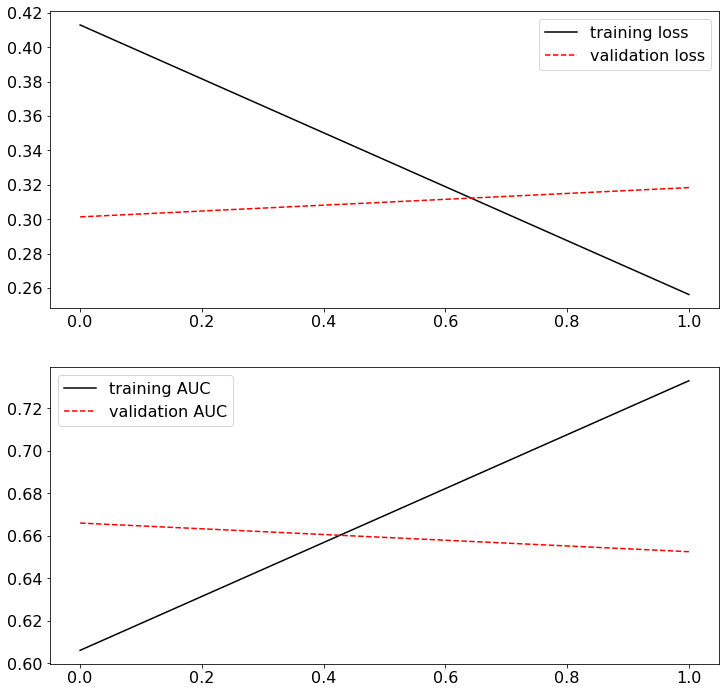

In [13]:
plt.rcParams.update({'font.size': 16})
hist = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(figsize=(12,12),nrows=2, ncols=1)
hist['loss'].plot(ax=ax1,c='k',label='training loss')
hist['val_loss'].plot(ax=ax1,c='r',linestyle='--', label='validation loss')
ax1.legend()
hist['auc'].plot(ax=ax2,c='k',label='training AUC')
hist['val_auc'].plot(ax=ax2,c='r',linestyle='--',label='validation AUC')
ax2.legend()
plt.show()

# Submissions

In [14]:
from sklearn.metrics import classification_report


test_dir = "../input/ranzcr-clip-catheter-line-classification/test_tfrecords"
TFR_fnames_test = tf.io.gfile.glob(test_dir + '/*.tfrec')

test_feature_map = {
    "StudyInstanceUID" : tf.io.FixedLenFeature([], tf.string),
    "image" : tf.io.FixedLenFeature([], tf.string)
    }

def read_tfr(example):
    
    example = tf.io.parse_single_example(example, test_feature_map)
    
    image = tf.io.decode_jpeg(example['image'])
    
    image = tf.image.resize(image, (img_size,img_size))
    
    image = tf.image.grayscale_to_rgb(image)
    
    image = image / 255
    
    return image



def load_ds(filenames):
    
    tfrecords = tf.data.TFRecordDataset(filenames)
    
    tfrecords = tfrecords.map(read_tfr, num_parallel_calls = autotune)
    
    return tfrecords
    
    
def get_ds(filenames):
    
    ds = load_ds(filenames)
    ds = ds.batch(4)
    ds = ds.prefetch(autotune)
    
    return ds

def read_ids(example):
    
    example = tf.io.parse_single_example(example, test_feature_map)
    ids = example['StudyInstanceUID']
    
    
    return ids

def load_ds_ids(filenames):
    
    tfrecords = tf.data.TFRecordDataset(filenames)
    
    tfrecords = tfrecords.map(read_ids, num_parallel_calls = autotune)
    
    return tfrecords
    
    
def get_ds_ids(filenames):
    
    ds = load_ds_ids(filenames)
    ds = ds.batch(test_samples)
    ds = ds.prefetch(autotune)
    
    return ds

test_samples = sum(1 for _ in tf.data.TFRecordDataset(TFR_fnames_test))
test_ds = get_ds(TFR_fnames_test)
test_ids = get_ds_ids(TFR_fnames_test)

y_preds = xception.predict(test_ds, batch_size=4)

results = pd.DataFrame(y_preds)

In [15]:
ids = next(iter(test_ids)).numpy()

for i in range(ids.shape[0]):
    ex = str(ids[i])
    ex = ex[2:-1]
    ids[i] = ex
ids = pd.Series(ids)

columns = ['StudyInstanceUID', 'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
           "NGT - Abnormal", 'NGT - Borderline','NGT - Incompletely Imaged',
           'NGT - Normal', 'CVC - Abnormal','CVC - Borderline',
           'CVC - Normal','Swan Ganz Catheter Present']

results_df = pd.concat([ids, results], axis = 1)
results_df.columns = columns
results_df.to_csv('submission.csv', index = False)

# References
1. https://www.kaggle.com/tpothjuan/efficientnetb7-resnet50-ensemble-tfrecords
2. https://keras.io/examples/keras_recipes/tfrecord/
3. https://arxiv.org/abs/1610.02357